# Packages

In [385]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
import numpy as np
from datetime import time, timedelta, datetime
import math 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ipywidgets
import statsmodels.stats.weightstats as sw
from statsmodels.stats.proportion import test_proportions_2indep
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from google.cloud import bigquery
from scipy.stats import norm
from scipy import stats
pd.options.display.float_format = "{:,.2f}".format
from scipy.stats import norm
from scipy import stats
import statsmodels.stats.weightstats as ws
import openpyxl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ambrosia.designer import Designer
from ambrosia.tester import Tester


import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind
from scipy import stats
from statsmodels.stats.proportion import test_proportions_2indep
from typing import List, Tuple, Union

# df["Week"] = df["Date"].dt.to_period("W").dt.to_timestamp()

bigquery_client = bigquery.Client(project='analytics-dev-333113')


## Functions

In [198]:
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {day} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    for date in daterange:
        print(f"Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                          )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                      )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                      )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                  )

        print('DataFrame is written to Excel File successfully.')

def get_minimal_determinable_effect(std, sample_size, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

def get_sample_size_abs(epsilon, std, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error

def srm_pivot(df):
    
    df_new_control = []
    df_new_variant = []
    
    for row in df:
        total = df.Control + df.Variant
        control = df.Control / total
        variant = df.Variant / total
        df_new_control.append(control)
        df_new_variant.append(variant)
        
    control_x = df_new_control[1]

    variant_x = df_new_variant[1]
    
    df_pivot_new = pd.DataFrame()
    
    df_pivot_new['Date'] = pd.to_datetime(df['date']).dt.date
    df_pivot_new['Control'] = df.Control
    df_pivot_new['Variant'] = df.Variant
    df_pivot_new['Total'] = df.Variant + df.Control
    
    df_pivot_new['Control_%'] = control_x
    df_pivot_new['Variant_%'] = variant_x
    
    df_pivot_new['Expected'] = (df.Control + df.Variant)/2
    
    chi_f = []
    chi_p = []
    
    for index, row in df_pivot_new.iterrows():
        control_x_x = row.Control
        variant_x_x = row.Variant
        
        observed_x = (row.Control, row.Variant)
        expected_x = (row.Control + row.Variant) / 2
        
        chi = st.chisquare(observed_x, f_exp = expected_x)
        
        chi_f.append(chi[0])
        chi_p.append(round(chi[1],20))
        
    df_pivot_new['chi_f'] = chi_f
    df_pivot_new['chi_p'] = chi_p
    
    
    df_plot_perc = df_pivot_new[['Date','Control_%', 'Variant_%']]
    
    dates = df_plot_perc['Date']
    
    plt.figure(figsize=(15,10))
    
    plot_perc = sns.lineplot(data = df_plot_perc)
    plot_perc.set_xticklabels(dates)
    plot_perc.set(ylim=(0.45, 0.55))
    
    df_plot_p = df_pivot_new[['Date','chi_p']]
    
    total_users_in_test = sum(df_pivot_new['Control']) + sum(df_pivot_new['Variant'])
    
    control = sum(df_pivot_new['Control']) / total_users_in_test
    variant = sum(df_pivot_new['Variant']) / total_users_in_test
    
    print(100*round(control,5),"% users are in the Control group.")
    print(100*round(variant,5),"% users are in the Variant group")
    
    observed = [sum(df_pivot_new['Control']), sum(df_pivot_new['Variant'])]
    
    total_traffic = sum(observed)
    
    expected = [total_traffic/2, total_traffic/2]
    
    chi = st.chisquare(observed, f_exp = expected)
    
    if chi[1] < 0.01:
        print("Sample ratio mismatch (SRM) may be present")
    else:
        print("Sample ratio mismatch (SRM) probably not present")
        
    return(df_pivot_new) 

def ttest(df, metric_col, ab_group_col, pairs_list=[('A', 'B')], ci=False, corrected_ci=0.95):
    """
    Welch t-test. Возвращает датафрейм с результатами всех попарных сравнений.
    
    df: DataFrame, датафрейм, который содержит колонки с поюзерной метрикой и группой.
    metric_col: float,int, имя столбца с метрикой
    ab_group_col: str, имя столбца с группой
    pairs_list: list, список пар сравнений
    corrected_ci: float, доверительный интервал, подразумевается, что он уже скорректирован под множественное сравнение.
    
    return res_table, датафрейм с результатами
    """
    res_table = pd.DataFrame()
    for pair in pairs_list:
        sample0 = df.loc[df[ab_group_col]==pair[0], metric_col]
        sample1 = df.loc[df[ab_group_col]==pair[1], metric_col]
        m0 = sample0.mean()
        m1 = sample1.mean()
        v0 = sample0.std()**2
        v1 = sample1.std()**2
        n0 = len(sample0)
        n1 = len(sample1)
        t, pvalue, df_ = ws.ttest_ind(
            sample0, 
            sample1, 
            alternative='two-sided', 
            usevar='unequal'
        )
        se = np.sqrt(v0 / n0 + v1 / n1)
        delta = m1 - m0
        delta_per = (m1/m0-1)*100

        print(f'\nСравнение групп: {pair[0]} и {pair[1]}')
        print(f't-statistic: {t}, pvalue: {pvalue}, df: {df_}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')

        if ci:
            tail = (1 + corrected_ci) / 2
            lb = delta - stats.t.ppf(tail, df_)*se 
            ub = delta + stats.t.ppf(tail, df_)*se
            lb_per = lb*100/m0
            ub_per = ub*100/m0
            print(f'Дов. интервал для delta: ({lb},{ub})')
            print(f'Дов. интервал для delta, %: ({lb_per},{ub_per})')
            result = pd.DataFrame(
                np.array([pair[0], pair[1], t, df_, pvalue, m0, m1, n0, n1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1,-1),
                columns=['group0', 'group1', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'sample0', 'sample1', 'diff_mean', 'diff_mean, %' ,'lb','ub', 'lb%', 'ub%']
            )
        else:
            result = pd.DataFrame(
                np.array([pair[0], pair[1], t, df_, pvalue, m0, m1, n0, n1, delta, delta_per]).reshape(1,-1),
                columns=['group0', 'group1', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'sample0', 'sample1', 'diff_mean', 'diff_mean, %']
            )
        res_table = pd.concat([res_table, result])
    return res_table

def prop_test_conversions(df, metric_col, ab_group_col, pairs_list=[('A', 'B')], corrected_ci=0.95):
    """
    Z-test для пропорций с коррекцией. Возвращает датафрейм с результатами всех попарных сравнений.

    df: DataFrame, датафрейм, который содержит колонки с поюзерной метрикой и группой.
    metric_col: float,int, имя столбца с метрикой
    ab_group_col: str, имя столбца с группой
    pairs_list: list, список пар сравнений
    corrected_ci: float, доверительный интервал, подразумевается, что он уже скорректирован под множественное сравнение.
    
    return res_table, датафрейм с результатами
    """
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        num0 = df[df[ab_group_col]==pair[0]][metric_col].sum()
        denom0 = df[df[ab_group_col]==pair[0]][metric_col].count()
        num1 = df[df[ab_group_col]==pair[1]][metric_col].sum()
        denom1 = df[df[ab_group_col]==pair[1]][metric_col].count()
        p0 = num0 / denom0
        p1 = num1 / denom1
        r = test_proportions_2indep(
            num0, denom0, 
            num1, denom1, 
            value=0, 
            method='wald', 
            compare='diff', 
            alternative='two-sided',
            correction=True, 
            return_results=True
        )
        se = np.sqrt(r.variance)
        delta = p1 - p0
        delta_per = (p1/p0-1)*100
        lb = delta - stats.norm.ppf(tail)*se 
        ub = delta + stats.norm.ppf(tail)*se
        lb_per = lb*100/p0
        ub_per = ub*100/p0
        
        # Если мы оцениваем другие интервалы, нужна ли поправка?
        #lb_0 = stats.beta(num0, denum0-num0).ppf(ci[0])
        #ub_0 = stats.beta(num0, denum0-num0).ppf(ci[1])
        #lb_1 = stats.beta(num1, denum1-num1).ppf(ci[0])
        # ub_1 = stats.beta(num1, denum1-num1).ppf(ci[1])
        
        print(f'\nСравнение групп: {pair[0]} и {pair[1]}')
        print(f'statistic: {r.statistic}, pvalue: {r.pvalue}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')
        print(f'Дов. интервал для delta: ({lb},{ub})')
        print(f'Дов. интервал для delta, %: ({lb_per},{ub_per})')
        result = pd.DataFrame(
            np.array([pair[0], pair[1], r.statistic, r.pvalue, p0, p1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1,-1),
            columns=['group0', 'group1', 'statistic','pvalue', 'mean0', 'mean1', 'diff_mean', 'diff_mean, %' ,'lb','ub', 'lb%', 'ub%']
        )
        res_table = pd.concat([res_table, result])
    return res_table

def method_benjamini_hochberg(pvalues, alpha=0.05):
    """Применяет метод Бенджамини-Хохберга для проверки значимости изменений.
    
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    Пример применения: df['Есть эффект?'] = method_benjamini_hochberg(df.pvalues)
    """
    m = len(pvalues)
    array_alpha = np.arange(1, m+1)
    array_alpha = alpha * array_alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

def calculate_results(users_data, 
                      bernulli_metrics = [('map_view', 'payment'), ('map_view', 'save_adr'), ('save_adr', 'payment')],
                      common_metrics = ['paid_gmv', 'orders_cnt'],
                      common_metrics_per_paid_users = [('paid_gmv', 'arppu')],
                      ratio_metrics = [('paid_gmv', 'orders_cnt', 'aov')],
                      pairs_list = [(0, 1)],
                      alpha = 0.05):
    
    """
    Example:

    r = calculate_results(res, 
                  bernulli_metrics = [('has_city_view', 'has_ml_passed'),
                                      ('has_city_view', 'has_ride')],
                  common_metrics=[('cnt_rides')],
                  common_metrics_per_paid_users=[],
                  ratio_metrics=[],
                  pairs_list = [(0, 1)],
                  alpha = 0.05)

    r['result'] = (r['pvalue'] < 0.05)*1
    r['result_with_corr'] = method_benjamini_hochberg(r['pvalue'].values)

    r_renamed = r[['metric', 'n0', 'n1', 'mean0', 'mean1', 'diff_mean', 'diff_mean, %', 'lb', 'ub', 'lb%', 'ub%', 'pvalue', 'result', 'result_with_corr']].rename(columns={
            'metric':'Metric',
            'n0':'Sample Size А',
            'n1':'Sample Size B',
            'mean0':'Value А',
            'mean1':'Value B',
            'diff_mean':'Diff Absolute',
            'diff_mean, %':'Diff Percent %',
            'lb':'LB',
            'ub':'UB',
            'lb%':'LB%',
            'ub%':'UB%',
            'pvalue' : 'Pval',
            'result' : 'Result',
            'result_with_corr': 'Result Corrected'})

    r_renamed
    """
    
    results_arr = []
    
    # conversions
    
    if len(bernulli_metrics)>0:
    
        bernulli_metrics_arr = []

        for metric in bernulli_metrics:
        
            step1, step2 = metric

            metric_name = 'cr {} to {}'.format(step1, step2)

            print()
            print(metric_name)

            for pair in pairs_list:
                bernulli_metrics_stats = prop_test_conversions(users_data[(users_data[step1]==1)], step2, 
                                                        'has_treatment', pairs_list=[pair], corrected_ci=1 - alpha)

                bernulli_metrics_stats['metric'] = metric_name

                bernulli_metrics_stats['n0'] = users_data[(users_data[step1]==1)&
                                                        (users_data['has_treatment']==pair[0])][step1].sum()

                bernulli_metrics_stats['n1'] = users_data[(users_data[step1]==1)&
                                                        (users_data['has_treatment']==pair[1])][step1].sum()
                bernulli_metrics_arr.append(bernulli_metrics_stats)
    
        bernulli_metrics_df = pd.concat(bernulli_metrics_arr)
        # bernulli_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]= bernulli_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]*100
        results_arr.append(bernulli_metrics_df)
    
    # common metrics
    
    common_metrics_arr = []
    
    if len(common_metrics)>0:
        
        for metric in common_metrics:

            print()
            print(metric)

            for pair in pairs_list:
                common_metrics_stats = ttest(users_data, metric, 'has_treatment', pairs_list=[pair],ci=True,  corrected_ci=1 - alpha)
                common_metrics_stats['metric'] = metric
                common_metrics_stats['n0'] = users_data[(users_data['has_treatment']==pair[0])][metric].count()
                common_metrics_stats['n1'] = users_data[(users_data['has_treatment']==pair[1])][metric].count()
                common_metrics_arr.append(common_metrics_stats)
        
        common_metrics_df = pd.concat(common_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        common_metrics_df.drop(columns=['df'], axis=1, inplace=True)
        results_arr.append(common_metrics_df)

    common_metrics_arr = []

    if len(common_metrics_per_paid_users)>0:
    
        for metric_info in common_metrics_per_paid_users:

            metric, metric_name = metric_info

            print()
            print(metric_name)

            for pair in pairs_list:
                common_metrics_per_paid_users_stats = ttest(users_data[users_data[metric]!=0], metric, 'has_treatment', pairs_list=[pair],ci=True,  corrected_ci=1 - alpha)

                common_metrics_per_paid_users_stats['metric'] = metric_name

                common_metrics_per_paid_users_stats['n0'] = users_data[(users_data[metric]!=0)&
                                                                    (users_data['has_treatment']==pair[0])][metric].count()
                common_metrics_per_paid_users_stats['n1'] = users_data[(users_data[metric]!=0)&
                                                                    (users_data['has_treatment']==pair[1])][metric].count()
                common_metrics_arr.append(common_metrics_per_paid_users_stats)

        common_metrics_df = pd.concat(common_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        common_metrics_df.drop(columns=['df'], axis=1, inplace=True)
        
        results_arr.append(common_metrics_df)
        
    # ration metrics
    
    if len(ratio_metrics)>0:
        ratio_metrics_arr = []

        for metric_info in ratio_metrics:

            nom_col, denom_col, metric_name = metric_info

            print()
            print(metric_name)

            for pair in pairs_list:
                ratio_metrics_stats = ttest_delta(users_data[users_data[denom_col]!=0], nom_col, denom_col, 
                                        'has_treatment', pairs_list=[pair], ci=True, corrected_ci=1 - alpha)

                ratio_metrics_stats['metric'] = metric_name

                ratio_metrics_stats['n0'] = users_data[(users_data[denom_col]!=0)&
                                                        (users_data['has_treatment']==pair[0])][denom_col].count()

                ratio_metrics_stats['n1'] = users_data[(users_data[denom_col]!=0)&
                                                    (users_data['has_treatment']==pair[1])][denom_col].count()

                ratio_metrics_arr.append(ratio_metrics_stats)

        ratio_metrics_df = pd.concat(ratio_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        ratio_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]= ratio_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]*100

        results_arr.append(ratio_metrics_df)
    
    results_data = pd.concat(results_arr).reset_index(drop=True)
    
    return results_data

# Experiment design

### MDE, Sample size, Period for each city

In [90]:
# CR of ML approve checks and cr to first ride after checking
df_success_ml = read_bq("""
WITH phc AS (SELECT t1.id,
                    check_uuid,
                    user_id,
                    t1.city_id,
                    t2.country_id,
                    t2.country_name,
                    status,
                    type,
                    created,
                    event,
                    modified,
                    event_by,
                    created_date_part,
                    photo_uploaded,
                    banner_date,
                    source,
                    check_date
             FROM dwh-storage-327422.photocontrol.events t1
                      JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                           ON t1.city_id = t2.city_id
             WHERE 1 = 1
               AND t1.created_date_part BETWEEN '2024-09-01' AND (CURRENT_DATE() - INTERVAL 1 DAY)
               AND t1.created_date_part NOT IN ('2024-10-09')
               AND t1.type IN ("TYPE_AUTO")
               AND t1.source = 'facechecker'
             QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, type, created_date_part ORDER BY modified DESC) = 1),
     rides AS (SELECT order_uuid,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-09-01')
SELECT user_id,
       country_name,
       MAX(IF((event = "EVENT_APPROVED" AND event_by = "EVENT_BY_ML"), 1, 0)) AS approved_by_ml_flg,
       MAX(IF((driverstarttheride_timestamp IS NOT NULL), 1, 0))              AS start_ride_flg,
FROM phc t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.driver_id
                       AND t2.driverstarttheride_timestamp BETWEEN t1.modified AND (t1.modified + INTERVAL 7 DAY)
GROUP BY 1, 2
""")

df_sample_size = read_bq("""
SELECT t1.city_id,
       t2.city_name,
       t2.country_id,
       t2.country_name,
       DATE(modified)                           AS modified,
       DATE_TRUNC(DATE(modified), WEEK(MONDAY)) AS modified_week,
       COUNT(DISTINCT user_id)                  AS users
FROM dwh-storage-327422.photocontrol.events t1
         JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
              ON t1.city_id = t2.city_id
WHERE 1 = 1
  AND t1.created_date_part BETWEEN '2024-09-01' AND (CURRENT_DATE() - INTERVAL 1 DAY)
  AND t1.created_date_part NOT IN ('2024-10-09')
  AND t1.type IN ("TYPE_AUTO")
  AND t1.event = 'EVENT_BANNER_SHOWED'
  AND t1.source = 'facechecker'
GROUP BY 1, 2, 3, 4, 5, 6
""")

df_sample_size['modified'] = pd.to_datetime(df_sample_size['modified'])
df_sample_size['modified_week'] = pd.to_datetime(df_sample_size['modified_week'])

In [114]:
# Preparing how many users actually hit the check

weekly = df_sample_size.groupby(['modified_week'], as_index=False)['users'].agg('sum')\
                       .query("modified_week not in ('2024-08-26', '2024-10-07', '2024-11-25')")['users'].mean().round(0)

daily = df_sample_size.groupby(['modified'], as_index=False)['users'].agg('sum')['users'].mean().round(0)

In [108]:
effects = [1.01, 1.015, 1.05, 1.1]  # MDE in percents
sizes = [int(daily), int(weekly), int(daily)*14, int(daily)*30]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.1, 0.2]

designer_target = Designer(
    dataframe=df_success_ml, 
    metrics='approved_by_ml_flg'
    )

designer_guardrail = Designer(
    dataframe=df_success_ml, 
    metrics='start_ride_flg'
    )

designer_target.set_first_errors(first_type_errors)
designer_target.set_second_errors(second_type_errors)

designer_guardrail.set_first_errors(first_type_errors)
designer_guardrail.set_second_errors(second_type_errors)


#### Considering business expectations on metric changes for Target indicator

In [ ]:
# Calculating sample size basing on business inquiries on metric uplift - share of approved by ML

designer_target.run(
    to_design='size', 
    method='theory', 
    effects=effects
    )

# Calculating power (Beta) for effect sizes as part of the alpha error levels

designer_target.run(
    to_design='power', 
    method='theory', 
    effects=effects, 
    sizes=sizes
    )


#### MDE for Guardrail and Target indicators

In [ ]:
# Here is calculating of potential minimal effect size which is MDE with help of featured sample volumes 1/7/14/30 days, respectively

target = designer_target.run(
    to_design='effect',
    method='theory',
    sizes=sizes
            )

target['Metric'] = 'Approved by ML (Target)'

target

abs_effect = (df_success_ml['approved_by_ml_flg'].mean()*1.015) - df_success_ml['approved_by_ml_flg'].mean()

In [ ]:
# The same as previous one for target metric but for guardrail in this case 

guard = designer_guardrail.run(
    to_design='effect',
    method='theory',
    sizes=sizes
            )

guard['Metric'] = 'CR to ride (Guardrail)'

guard

In [ ]:
# Concatenation of two key indicators in terms of MDE calculation 

pd.concat([target, guard])

# Summarizing 

### Data preparing 

Start date and time
02.12.24
23:59 UTC
—
End date and time
17.12.24
23:59 UTC

In [386]:
# CR of ML approve checks and cr to first ride after checking
df_success_ml_and_rides = read_bq("""
WITH users AS (SELECT user_id,
                      t1.city_id,
                      t2.city_name,
                      t2.country_name,
                      t2.country_id,
                      IF(group_id = 4526435, 'control', 'treatment') AS segment,
                      IF(group_id = 4526435, 0, 1)                   AS segment_binary,
                      created_dt_part
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                             ON t1.city_id = t2.city_id
               WHERE test_id = 2272),
     phc AS (SELECT t1.id,
                    check_uuid,
                    user_id,
                    t1.city_id,
                    t2.country_id,
                    t2.country_name,
                    status,
                    type,
                    created,
                    event,
                    modified,
                    event_by,
                    created_date_part,
                    photo_uploaded,
                    banner_date,
                    source,
                    check_date
             FROM dwh-storage-327422.photocontrol.events t1
                      JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                           ON t1.city_id = t2.city_id
             WHERE 1 = 1
               AND t1.created_date_part >= '2024-12-02'
               AND LOWER(t1.type) IN ("type_avatar", 'type_auto')
               AND t1.source = 'facechecker'
             QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, type, created_date_part ORDER BY modified DESC) = 1),
     rides AS (SELECT order_uuid,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-12-02')
SELECT t1.user_id,
       t1.segment,
       t1.segment_binary,
       t1.created_dt_part,
       t1.city_id,
       t1.city_name,
       t1.country_id,
       t1.country_name,
       t2.type,
       event,
       event_by,
       MAX(IF((event = "EVENT_APPROVED" AND event_by = "EVENT_BY_ML"), 1, 0)) AS approved_by_ml_flg,
       MAX(IF((event = "EVENT_APPROVED"), 1, 0))                              AS approved_at_all,
       MAX(IF((driverstarttheride_timestamp IS NOT NULL), 1, 0))              AS start_ride_flg
FROM users t1
         JOIN phc t2
              ON t1.user_id = t2.user_id
                  AND DATE(t2.modified) >= t1.created_dt_part
                  AND t2.event = 'EVENT_APPROVED'
         LEFT JOIN rides t3
                   ON t1.user_id = t3.driver_id
                       AND t3.driverstarttheride_timestamp BETWEEN t2.modified AND (t2.modified + INTERVAL 7 DAY)
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
""")

# Common % of approved whether it be making by moderator or model
df_approved_at_all = read_bq("""
WITH users AS (SELECT user_id,
                      t1.city_id,
                      t2.city_name,
                      t2.country_name,
                      t2.country_id,
                      IF(group_id = 4526435, 'control', 'treatment') AS segment,
                      IF(group_id = 4526435, 0, 1)                   AS segment_binary,
                      created_dt_part
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                             ON t1.city_id = t2.city_id
               WHERE test_id = 2272),
     phc AS (SELECT t1.id,
                    check_uuid,
                    user_id,
                    t1.city_id,
                    t2.country_id,
                    t2.country_name,
                    status,
                    type,
                    created,
                    event,
                    modified,
                    event_by,
                    created_date_part,
                    photo_uploaded,
                    banner_date,
                    source,
                    check_date
             FROM dwh-storage-327422.photocontrol.events t1
                      JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                           ON t1.city_id = t2.city_id
             WHERE 1 = 1
               AND t1.created_date_part >= '2024-12-02'
               AND LOWER(t1.type) IN ("type_avatar", 'type_auto')
               AND t1.source = 'facechecker'
             QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, type, created_date_part ORDER BY modified DESC) = 1),
     rides AS (SELECT order_uuid,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-12-02')
SELECT t1.user_id,
       t1.segment,
       t1.segment_binary,
       t1.created_dt_part,
       t1.city_id,
       t1.city_name,
       t1.country_id,
       t1.country_name,
       t2.type,
       event,
       event_by,
       MAX(IF((event = "EVENT_APPROVED" AND event_by = "EVENT_BY_ML"), 1, 0)) AS approved_by_ml_flg,
       MAX(IF((event = "EVENT_APPROVED"), 1, 0))                              AS approved_at_all,
       MAX(IF((driverstarttheride_timestamp IS NOT NULL), 1, 0))              AS start_ride_flg
FROM users t1
         JOIN phc t2
              ON t1.user_id = t2.user_id
                  AND DATE(t2.modified) >= t1.created_dt_part
         LEFT JOIN rides t3
                   ON t1.user_id = t3.driver_id
                       AND t3.driverstarttheride_timestamp BETWEEN t2.modified AND (t2.modified + INTERVAL 7 DAY)
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
""")

# How long it takes to complete
df_check_duration = read_bq("""
WITH users AS (SELECT user_id,
                      t1.city_id,
                      t2.city_name,
                      t2.country_name,
                      t2.country_id,
                      IF(group_id = 4526435, 'control', 'treatment') AS segment,
                      IF(group_id = 4526435, 0, 1)                   AS segment_binary,
                      created_dt_part
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                             ON t1.city_id = t2.city_id
               WHERE test_id = 2272),
     phc AS (SELECT t1.id,
                    check_uuid,
                    user_id,
                    t1.city_id,
                    t2.country_id,
                    t2.country_name,
                    status,
                    type,
                    created,
                    event,
                    modified,
                    event_by,
                    created_date_part,
                    photo_uploaded,
                    banner_date,
                    source,
                    check_date
             FROM dwh-storage-327422.photocontrol.events t1
                      JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                           ON t1.city_id = t2.city_id
             WHERE 1 = 1
               AND t1.created_date_part >= '2024-12-02'
               AND LOWER(t1.type) IN ("type_avatar", 'type_auto')
               AND t1.source = 'facechecker'),
     rides AS (SELECT order_uuid,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-12-02')
SELECT t1.user_id,
       t1.segment,
       t1.segment_binary,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       t1.country_id,
       t2.type,
       MIN(IF((event = "EVENT_SHOWED"), t2.modified, NULL))                                    AS banner_click_dttm,
       MIN(IF((event = "EVENT_PHOTO_UPLOADED"), t2.modified, NULL))                            AS photo_uploaded_dttm,
       MIN(IF((event = "EVENT_APPROVED"), t2.modified, NULL))                                  AS approved_at_all_dttm,
       MIN(IF((driverstarttheride_timestamp IS NOT NULL), driverstarttheride_timestamp, NULL)) AS first_ride_dttm,
       DATE_DIFF(MIN(IF((event = "EVENT_APPROVED"), t2.modified, NULL)),
                 MIN(IF((event = "EVENT_SHOWED"), t2.modified, NULL)), SECOND)                 AS click_to_approve,
       DATE_DIFF(MIN(IF((event = "EVENT_APPROVED"), t2.modified, NULL)),
                 MIN(IF((event = "EVENT_PHOTO_UPLOADED"), t2.modified, NULL)), SECOND)         AS photo_to_approve,
       DATE_DIFF(MIN(IF((driverstarttheride_timestamp IS NOT NULL), driverstarttheride_timestamp, NULL)),
                 MIN(IF((event = "EVENT_PHOTO_UPLOADED"), t2.modified, NULL)), SECOND)         AS photo_to_ride,
       DATE_DIFF(MIN(IF((driverstarttheride_timestamp IS NOT NULL), driverstarttheride_timestamp, NULL)),
                 MIN(IF((event = "EVENT_APPROVED"), t2.modified, NULL)), SECOND)               AS photo_to_ride
FROM users t1
         JOIN phc t2
              ON t1.user_id = t2.user_id
                  AND DATE(t2.modified) >= t1.created_dt_part
         LEFT JOIN rides t3
                   ON t1.user_id = t3.driver_id
                       AND t2.event = 'EVENT_APPROVED'
                       AND t3.driverstarttheride_timestamp BETWEEN t2.modified AND (t2.modified + INTERVAL 7 DAY)
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
""")

### Sample ratio mismatch checking

In [388]:
srm_df = pd.DataFrame()
new_srm_df = pd.DataFrame()

for city in df_success_ml_and_rides['country_name'].unique():

    for type in df_success_ml_and_rides['type'].unique():
    
        observed = [
            (df_success_ml_and_rides.query(f'segment == "control" and country_name == "{city}" and type == "{type}"')['user_id'].count()), 
            (df_success_ml_and_rides.query(f'segment == "treatment" and country_name == "{city}" and type == "{type}"')['user_id'].count())
            ]

        total_traffic = sum(observed)

        expected = [total_traffic/2, total_traffic/2]

        chi = st.chisquare(observed, f_exp = expected)

        country_id = list(df_success_ml_and_rides[['country_name', 'country_id']].query(f'country_name == "{city}"')['country_id'])[0]

        if chi[1] < 0.01:
            conclusion = "Sample ratio mismatch (SRM) may be present"
        else:
            conclusion = "Sample ratio mismatch (SRM) probably not present"
            print(f"{city}, {country_id}")

        
        new_srm_df = pd.DataFrame(
            [[city, country_id, type, observed, total_traffic, expected, round(chi[1], 3), conclusion]], 
            columns=['country_name', 'country_id', 'type', 'sample_sizes', 'total_size', 'expected_sizes', 'chi_value', 'conclusion']
            )

        srm_df = pd.concat([srm_df, new_srm_df]).sort_values(['country_name', 'type', 'total_size'], ascending=False).reset_index(drop=True)

srm_df

Malaysia, 85
Malaysia, 85
Казахстан, 2
Казахстан, 2
Panama, 77
Panama, 77
Zimbabwe, 70
Zimbabwe, 70
Tunisia, 31
Tunisia, 31
Turkey, 84
Turkey, 84
Кыргызстан, 5
Кыргызстан, 5
Tanzania, 9
Tanzania, 9
Украина, 6
Украина, 6
Namibia, 58
Namibia, 58
Botswana, 50
Botswana, 50
Ghana, 53
Ghana, 53
USA, 7
Zambia, 69
Zambia, 69
Uganda, 29
Uganda, 29
Philippines, 16
United Kingdom, 216
United Kingdom, 216
Côte d'Ivoire, 109
Côte d'Ivoire, 109
Dominican Republic, 46
Dominican Republic, 46
Democratic Republic of the Congo, 150
Democratic Republic of the Congo, 150
Maldives, 138
Maldives, 138
Egypt, 153
Egypt, 153
Pakistan, 60
Pakistan, 60
Kenya, 8
Kenya, 8


,country_name,country_id,type,sample_sizes,total_size,expected_sizes,chi_value,conclusion
0,Украина,6,TYPE_AVATAR,"[20, 9]",29,"[14.5, 14.5]",0.04,Sample ratio mismatch (SRM) probably not present
1,Украина,6,TYPE_AUTO,"[229, 220]",449,"[224.5, 224.5]",0.67,Sample ratio mismatch (SRM) probably not present
2,Кыргызстан,5,TYPE_AVATAR,"[840, 897]",1737,"[868.5, 868.5]",0.17,Sample ratio mismatch (SRM) probably not present
3,Кыргызстан,5,TYPE_AUTO,"[903, 932]",1835,"[917.5, 917.5]",0.50,Sample ratio mismatch (SRM) probably not present
4,Казахстан,2,TYPE_AVATAR,"[115776, 115650]",231426,"[115713.0, 115713.0]",0.79,Sample ratio mismatch (SRM) probably not present
5,Казахстан,2,TYPE_AUTO,"[66450, 66731]",133181,"[66590.5, 66590.5]",0.44,Sample ratio mismatch (SRM) probably not present
6,Zimbabwe,70,TYPE_AVATAR,"[775, 823]",1598,"[799.0, 799.0]",0.23,Sample ratio mismatch (SRM) probably not present
7,Zimbabwe,70,TYPE_AUTO,"[688, 708]",1396,"[698.0, 698.0]",0.59,Sample ratio mismatch (SRM) probably not present
8,Zambia,69,TYPE_AVATAR,"[2, 3]",5,"[2.5, 2.5]",0.66,Sample ratio mismatch (SRM) probably not present
9,Zambia,69,TYPE_AUTO,"[1, 2]",3,"[1.5, 1.5]",0.56,Sample ratio mismatch (SRM) probably not present


In [389]:
srm_df[srm_df['country_id'].isin(set(srm_df.query("total_size > 200 and conclusion == 'Sample ratio mismatch (SRM) probably not present'")['country_id']))]

,country_name,country_id,type,sample_sizes,total_size,expected_sizes,chi_value,conclusion
0,Украина,6,TYPE_AVATAR,"[20, 9]",29,"[14.5, 14.5]",0.04,Sample ratio mismatch (SRM) probably not present
1,Украина,6,TYPE_AUTO,"[229, 220]",449,"[224.5, 224.5]",0.67,Sample ratio mismatch (SRM) probably not present
2,Кыргызстан,5,TYPE_AVATAR,"[840, 897]",1737,"[868.5, 868.5]",0.17,Sample ratio mismatch (SRM) probably not present
3,Кыргызстан,5,TYPE_AUTO,"[903, 932]",1835,"[917.5, 917.5]",0.50,Sample ratio mismatch (SRM) probably not present
4,Казахстан,2,TYPE_AVATAR,"[115776, 115650]",231426,"[115713.0, 115713.0]",0.79,Sample ratio mismatch (SRM) probably not present
5,Казахстан,2,TYPE_AUTO,"[66450, 66731]",133181,"[66590.5, 66590.5]",0.44,Sample ratio mismatch (SRM) probably not present
6,Zimbabwe,70,TYPE_AVATAR,"[775, 823]",1598,"[799.0, 799.0]",0.23,Sample ratio mismatch (SRM) probably not present
7,Zimbabwe,70,TYPE_AUTO,"[688, 708]",1396,"[698.0, 698.0]",0.59,Sample ratio mismatch (SRM) probably not present
16,Turkey,84,TYPE_AVATAR,"[2067, 2006]",4073,"[2036.5, 2036.5]",0.34,Sample ratio mismatch (SRM) probably not present
17,Turkey,84,TYPE_AUTO,"[303, 293]",596,"[298.0, 298.0]",0.68,Sample ratio mismatch (SRM) probably not present


In [390]:
df_success_ml_and_rides_corrected = df_success_ml_and_rides.query("country_id in (2, 5, 70, 6, 9, 77, 50, 84, 85, 53, 31)")
df_approved_at_all_corrected = df_approved_at_all.query("country_id in (2, 5, 70, 6, 9, 77, 50, 84, 85, 53, 31)")
df_check_duration_corrected = df_check_duration.query("country_id in (2, 5, 70, 6, 9, 77, 50, 84, 85, 53, 31)")

### Cummulitive P-Value over the period

In [391]:
def plot_p_value_distribution(
    control_group: np.ndarray,
    test_group: np.ndarray,
    num_tests: int = 1000
) -> None:
    """Plot the distribution of p-values from A/A tests."""
    np.random.seed(42)

    p_values = [
        ttest_ind(np.random.choice(control_group, size=len(control_group), replace=True),
                  np.random.choice(test_group, size=len(test_group), replace=True), equal_var=False)[1]
        for _ in tqdm(range(num_tests))
    ]
    
    plt.figure(figsize=(15, 6))
    plt.hist(p_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', label='Significance level (0.05)')
    plt.title('P-value Distribution from A/A Tests', fontsize=14)
    plt.xlabel('P-value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

In [453]:
df_success_ml_and_rides_corrected.groupby(['segment', 'country_name', 'type'], as_index=False)[['approved_by_ml_flg', 'start_ride_flg']].mean() # std seems like they are equal to each other to use

df_success_ml_and_rides_corrected.pivot_table(columns=['type', 'segment'], index='country_name', values=['approved_by_ml_flg', 'start_ride_flg'], aggfunc='mean')

approved_by_ml_flg                                  \
type                  TYPE_AUTO           TYPE_AVATAR             
segment                 control treatment     control treatment   
country_name                                                      
Botswana                   0.36      0.30        0.72      0.71   
Ghana                      0.42      0.33        0.83      0.81   
Malaysia                   0.42      0.42        0.91      0.89   
Panama                     0.20      0.17        0.89      0.89   
Tanzania                   0.28      0.46        0.75      0.78   
Tunisia                    0.25      0.20        0.79      0.84   
Turkey                     0.23      0.19        0.86      0.86   
Zimbabwe                   0.24      0.23        0.73      0.74   
Казахстан                  0.34      0.34        0.86      0.86   
Кыргызстан                 0.30      0.30        0.83      0.83   
Украина                    0.00      0.00        0.10      0.22   

             start_ride_flg                                  
type              TYPE_AUTO           TYPE_AVATAR            
segment             control treatment     control treatment  
country_name                                                 
Botswana               0.78      0.79        0.77      0.73  
Ghana                  0.37      0.52        0.41      0.43  
Malaysia               0.65      0.64        0.70      0.69  
Panama                 0.77      0.79        0.73      0.75  
Tanzania               0.58      0.60        0.53      0.49  
Tunisia                0.62      0.71        0.69      0.66  
Turkey                 0.51      0.49        0.49      0.49  
Zimbabwe               0.75      0.74        0.74      0.75  
Казахстан              0.67      0.67        0.67      0.67  
Кыргызстан             0.49      0.46        0.45      0.44  
Украина                0.60      0.62        0.50      0.56

In [452]:
df_approved_at_all_corrected.groupby(['segment', 'country_name', 'type'], as_index=False)['approved_at_all'].mean() # binary metric

df_approved_at_all_corrected.pivot_table(columns=['type', 'segment'], index=['country_name'], values='approved_at_all', aggfunc='mean')

type         TYPE_AUTO           TYPE_AVATAR          
segment        control treatment     control treatment
country_name                                          
Botswana          0.47      0.50        0.48      0.54
Ghana             0.48      0.38        0.62      0.61
Malaysia          0.46      0.48        0.71      0.71
Panama            0.41      0.42        0.64      0.65
Tanzania          0.42      0.42        0.70      0.66
Tunisia           0.46      0.46        0.62      0.62
Turkey            0.54      0.53        0.69      0.69
Zimbabwe          0.47      0.46        0.51      0.51
Казахстан         0.49      0.49        0.63      0.63
Кыргызстан        0.44      0.44        0.47      0.50
Украина           0.89      0.89        0.87      0.82

In [394]:
df_check_duration_corrected[df_check_duration_corrected['photo_to_approve']>0].groupby(['segment', 'type'], as_index=False)['photo_to_approve'].median() # quantitive metric

,segment,type,photo_to_approve
0,control,TYPE_AUTO,"9,797.00"
1,control,TYPE_AVATAR,2.00
2,treatment,TYPE_AUTO,"10,220.00"
3,treatment,TYPE_AVATAR,2.00


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

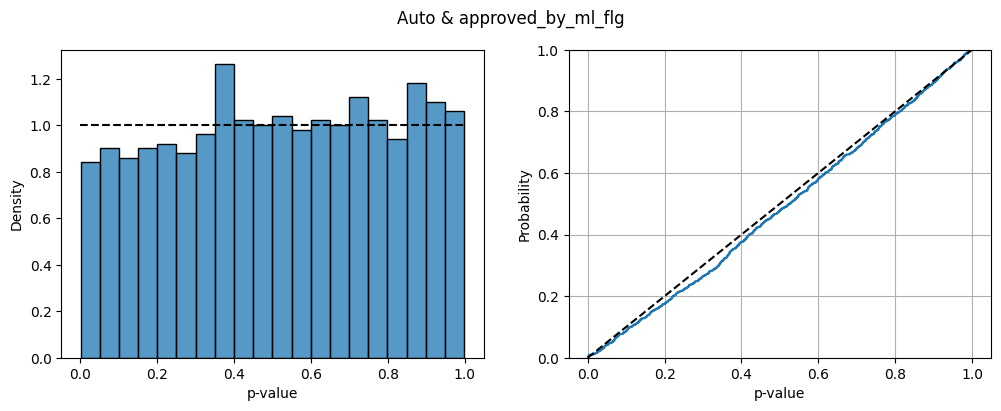

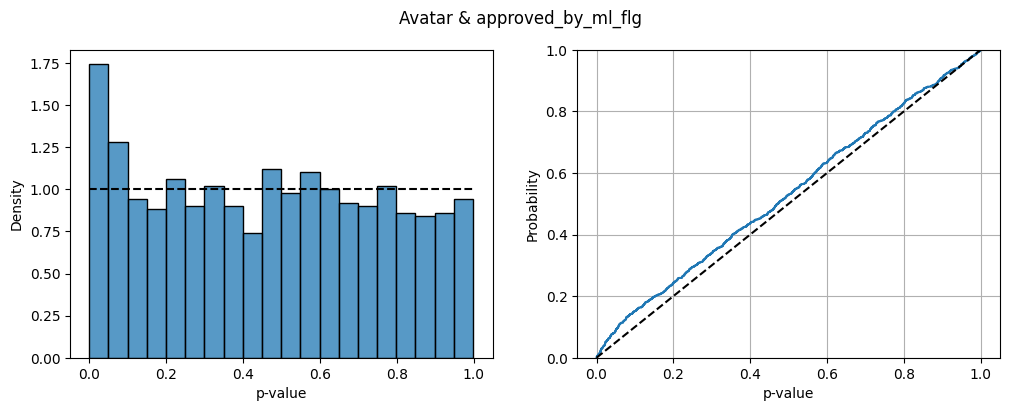

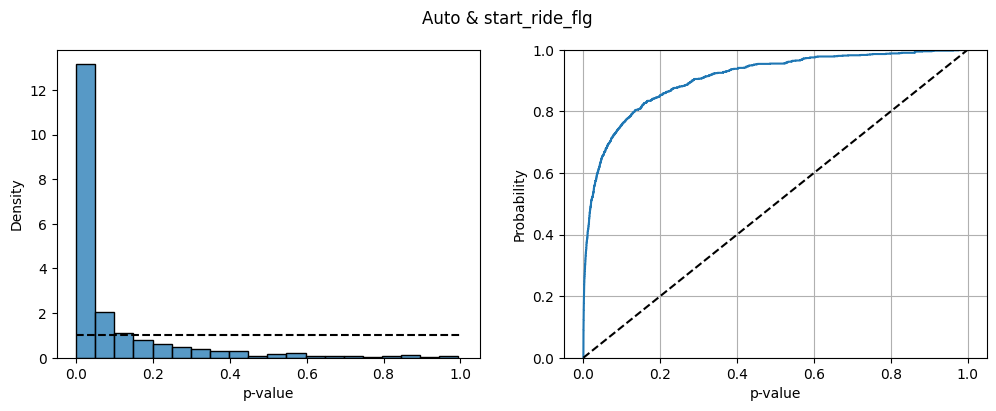

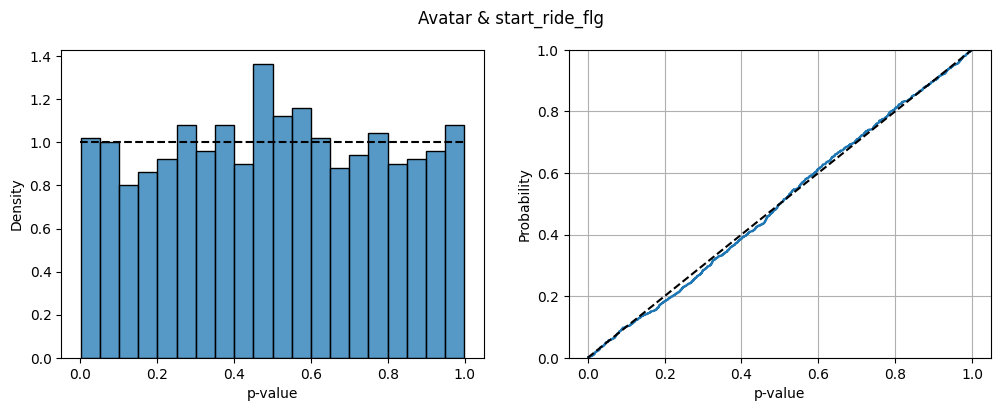

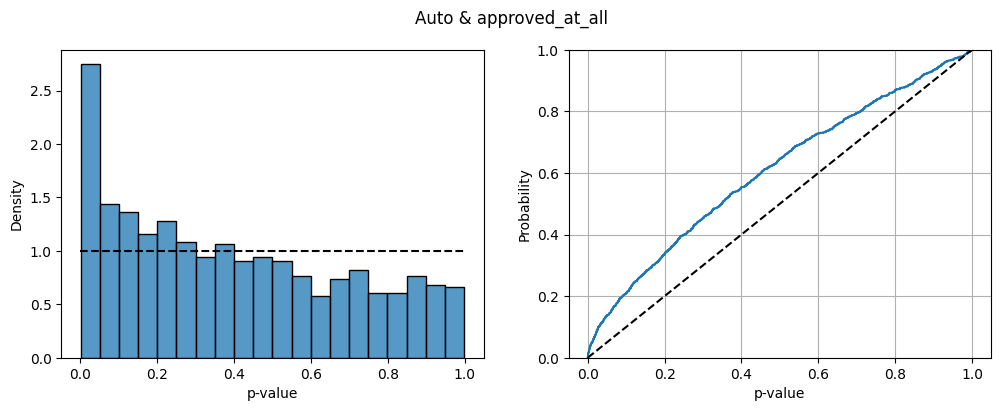

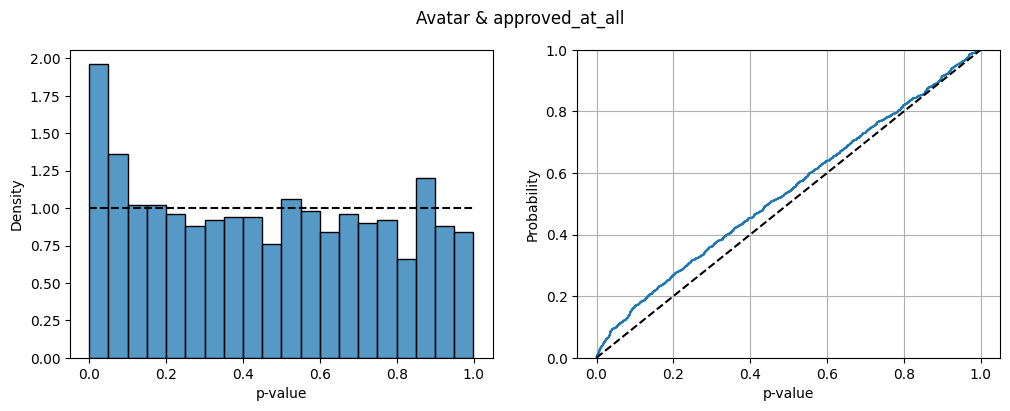

In [395]:
# Checking the actually Error type 2 and Power as well as checking the indicator behavior

metrics = ['approved_by_ml_flg', 'start_ride_flg']

for metric in metrics:

    control_group_auto = list(df_success_ml_and_rides_corrected.query("segment == 'control' and type == 'TYPE_AUTO'")[metric])
    test_group_auto = list(df_success_ml_and_rides_corrected.query("segment == 'treatment' and type == 'TYPE_AUTO'")[metric])

    control_group_avatar = list(df_success_ml_and_rides_corrected.query("segment == 'control' and type == 'TYPE_AVATAR'")[metric])
    test_group_avatar = list(df_success_ml_and_rides_corrected.query("segment == 'treatment' and type == 'TYPE_AVATAR'")[metric])

    p_values_auto = [
            ttest_ind(np.random.choice(control_group_auto, size=len(control_group_auto), replace=True),
                    np.random.choice(test_group_auto, size=len(test_group_auto), replace=True), equal_var=False)[1]
            for _ in tqdm(range(1000))
        ]

    p_values_avatar = [
            ttest_ind(np.random.choice(control_group_avatar, size=len(control_group_avatar), replace=True),
                    np.random.choice(test_group_avatar, size=len(test_group_avatar), replace=True), equal_var=False)[1]
            for _ in tqdm(range(1000))
        ]
    
    plot_pvalue_ecdf(p_values_auto, title=f'Auto & {metric}')
    plot_pvalue_ecdf(p_values_avatar, title=f'Avatar & {metric}')


control_group_auto = list(df_approved_at_all_corrected.query("segment == 'control' and type == 'TYPE_AUTO'")['approved_at_all'])
test_group_auto = list(df_approved_at_all_corrected.query("segment == 'treatment' and type == 'TYPE_AUTO'")['approved_at_all'])

control_group_avatar = list(df_approved_at_all_corrected.query("segment == 'control' and type == 'TYPE_AVATAR'")['approved_at_all'])
test_group_avatar = list(df_approved_at_all_corrected.query("segment == 'treatment' and type == 'TYPE_AVATAR'")['approved_at_all'])

p_values_auto = [
            ttest_ind(np.random.choice(control_group_auto, size=len(control_group_auto), replace=True),
                    np.random.choice(test_group_auto, size=len(test_group_auto), replace=True), equal_var=False)[1]
            for _ in tqdm(range(1000))
        ]

p_values_avatar = [
        ttest_ind(np.random.choice(control_group_avatar, size=len(control_group_avatar), replace=True),
                np.random.choice(test_group_avatar, size=len(test_group_avatar), replace=True), equal_var=False)[1]
        for _ in tqdm(range(1000))
]

plot_pvalue_ecdf(p_values_auto, title=f'Auto & approved_at_all')
plot_pvalue_ecdf(p_values_avatar, title=f'Avatar & approved_at_all')

### Effect calculating (Applying criteria and using charts)

In [426]:
def prop_test_conversions(
    df: pd.DataFrame,
    metric_col: str,
    ab_group_col: str,
    pairs_list: List[Tuple[str, str]] = [('A', 'B')],
    corrected_ci: float = 0.95
) -> pd.DataFrame:
    """Perform proportion tests between two groups."""
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        num0 = df[df[ab_group_col] == pair[0]][metric_col].sum()
        denom0 = df[df[ab_group_col] == pair[0]][metric_col].count()
        num1 = df[df[ab_group_col] == pair[1]][metric_col].sum()
        denom1 = df[df[ab_group_col] == pair[1]][metric_col].count()
        group0_sample_size = df[df[ab_group_col] == pair[0]][metric_col].count()
        group1_sample_size = df[df[ab_group_col] == pair[1]][metric_col].count()
        p0 = num0 / denom0
        p1 = num1 / denom1
        r = test_proportions_2indep(
            num0, denom0,
            num1, denom1,
            value=0,
            method='wald',
            compare='diff',
            alternative='two-sided',
            correction=True,
            return_results=True
        )
        se = np.sqrt(r.variance)
        delta = p1 - p0
        delta_per = (p1 / p0 - 1) * 100
        lb = delta - stats.norm.ppf(tail) * se
        ub = delta + stats.norm.ppf(tail) * se
        lb_per = lb * 100 / p0
        ub_per = ub * 100 / p0
        
        print(f'\nComparison between groups: {pair[0]} and {pair[1]}')
        print(f'Metric: {metric_col}')
        print(f'statistic: {r.statistic}, pvalue: {r.pvalue}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')
        print(f'Confidence interval for delta: ({lb}, {ub})')
        print(f'Confidence interval for delta, %: ({lb_per}, {ub_per})')

        result = pd.DataFrame(
            np.array([metric_col, pair[0], pair[1], group0_sample_size, group1_sample_size, r.statistic, r.pvalue, p0, p1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1, -1),
            columns=['metric_name', 'group0', 'group1', 'group0_sample_size', 'group1_sample_size', 'statistic', 'pvalue', 'mean0', 'mean1', 'diff_mean', 'diff_mean, %', 'lower_boundary', 'upper_boundary', 'lower_boundary_%', 'upper_boundary_%']
        )
        res_table = pd.concat([res_table, result])
    return res_table

def ttest(
    df: pd.DataFrame,
    metric_col: str,
    ab_group_col: str,
    pairs_list: List[Tuple[str, str]] = [('A', 'B')],
    corrected_ci: float = 0.95
) -> pd.DataFrame:
    """Perform t-tests between two groups."""
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        sample0 = df.loc[df[ab_group_col] == pair[0], metric_col]
        sample1 = df.loc[df[ab_group_col] == pair[1], metric_col]
        m0 = sample0.mean()
        m1 = sample1.mean()
        v0 = sample0.std()**2
        v1 = sample1.std()**2
        n0 = len(sample0)
        n1 = len(sample1)
        t, pvalue, df_ = ws.ttest_ind(
            sample0,
            sample1,
            alternative='two-sided',
            usevar='unequal'
        )
        se = np.sqrt(v0 / n0 + v1 / n1)
        delta = m1 - m0
        delta_per = (m1 / m0 - 1) * 100
        lb = delta - stats.t.ppf(tail, df_) * se
        ub = delta + stats.t.ppf(tail, df_) * se
        lb_per = lb * 100 / m0
        ub_per = ub * 100 / m0
        
        print(f'\nComparison between groups: {pair[0]} and {pair[1]}')
        print(f'Metric: {metric_col}')
        print(f't-statistic: {t}, pvalue: {pvalue}, df: {df_}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')
        print(f'Confidence interval for delta: ({lb}, {ub})')
        print(f'Confidence interval for delta, %: ({lb_per}, {ub_per})')

        result = pd.DataFrame(
            np.array([metric_col, pair[0], pair[1], n0, n1, t, df_, pvalue, m0, m1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1, -1),
            columns=['metric_name', 'group0', 'group1', 'group0_sample_size', 'group1_sample_size', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'diff_mean', 'diff_mean_%', 'lower_boundary', 'upper_boundary', 'lower_boundary_%', 'upper_boundary_%']
        )
        res_table = pd.concat([res_table, result])
    return res_table

In [454]:
# Calculatin the metrics

approved_by_ml_flg_auto = prop_test_conversions(
    df_success_ml_and_rides_corrected.query("type == 'TYPE_AUTO'"),
    'approved_by_ml_flg',
    'segment_binary',
    [(0, 1)]
)
approved_by_ml_flg_auto['type'] = 'AUTO'

approved_by_ml_flg_avatar = prop_test_conversions(
    df_success_ml_and_rides_corrected.query("type == 'TYPE_AVATAR'"),
    'approved_by_ml_flg',
    'segment_binary',
    [(0, 1)]
)
approved_by_ml_flg_avatar['type'] = 'AVATAR'

start_ride_flg_auto = prop_test_conversions(
    df_success_ml_and_rides_corrected.query("type == 'TYPE_AUTO'"),
    'start_ride_flg',
    'segment_binary',
    [(0, 1)]
)
start_ride_flg_auto['type'] = 'AUTO'

start_ride_flg_avatar = prop_test_conversions(
    df_success_ml_and_rides_corrected.query("type == 'TYPE_AVATAR'"),
    'start_ride_flg',
    'segment_binary',
    [(0, 1)]
)
start_ride_flg_avatar['type'] = 'AVATAR'

approved_at_all_auto = prop_test_conversions(
    df_approved_at_all_corrected.query("type == 'TYPE_AUTO'"),
    'approved_at_all',
    'segment_binary',
    [(0, 1)]
)
approved_at_all_auto['type'] = 'AUTO'

approved_at_all_avatar = prop_test_conversions(
    df_approved_at_all_corrected.query("type == 'TYPE_AVATAR'"),
    'approved_at_all',
    'segment_binary',
    [(0, 1)]
)
approved_at_all_avatar['type'] = 'AVATAR'

photo_to_approve_auto = ttest(
    df_check_duration_corrected[
        ~df_check_duration_corrected['photo_to_approve'].isna()
    ].query("type == 'TYPE_AUTO'"),
    'photo_to_approve',
    'segment_binary',
    [(0, 1)]
)
photo_to_approve_auto['type'] = 'AUTO'

photo_to_approve_avatar = ttest(
    df_check_duration_corrected[
        ~df_check_duration_corrected['photo_to_approve'].isna()
    ].query("type == 'TYPE_AVATAR'"),
    'photo_to_approve',
    'segment_binary',
    [(0, 1)]
)
photo_to_approve_avatar['type'] = 'AVATAR'

# Union of total result into one table
total_result_df = pd.concat([
    approved_by_ml_flg_auto,
    approved_by_ml_flg_avatar,
    start_ride_flg_auto,
    start_ride_flg_avatar,
    approved_at_all_auto,
    approved_at_all_avatar,
    photo_to_approve_auto,
    photo_to_approve_avatar
])

# Changing the types of data
for column in total_result_df.columns[-3:]:
    total_result_df[column] = total_result_df[column].astype('float')

for column in total_result_df.columns[1:-4]:
    total_result_df[column] = total_result_df[column].astype('float')


Comparison between groups: 0 and 1
Metric: approved_by_ml_flg
statistic: 0.14653989831088668, pvalue: 0.8834951955551699
delta = -0.0003669316119583321
delta,% = -0.10877885026737699%
Confidence interval for delta: (-0.005274624005069057, 0.004540760781152392)
Confidence interval for delta, %: (-1.5636906610523738, 1.3461329605176129)

Comparison between groups: 0 and 1
Metric: approved_by_ml_flg
statistic: 0.41657139525815406, pvalue: 0.6769919357017056
delta = -0.000579015902187674
delta,% = -0.06740470528456832%
Confidence interval for delta: (-0.0033032795642678027, 0.002145247759892455)
Confidence interval for delta, %: (-0.38454312681352654, 0.2497337162443931)

Comparison between groups: 0 and 1
Metric: start_ride_flg
statistic: -2.363269855750708, pvalue: 0.01811447387695904
delta = 0.0058998451799775475
delta,% = 0.8886016818741682%
Confidence interval for delta: (0.0010068432068935165, 0.010792847153061579)
Confidence interval for delta, %: (0.1516450923263985, 1.62555827142

In [451]:
total_result_df

,metric_name,group0,group1,group0_sample_size,group1_sample_size,statistic,pvalue,mean0,mean1,diff_mean,"diff_mean, %",lower_boundary,upper_boundary,lower_boundary_%,upper_boundary_%,type,t_statistic,df,diff_mean_%
0,approved_by_ml_flg,0.00,1.00,"71,090.00","71,482.00",0.15,0.88,0.34,0.34,-0.00,-0.11,-0.01,0.00,-1.56,1.35,AUTO,NaN,NaN,NaN
0,approved_by_ml_flg,0.00,1.00,"125,587.00","125,589.00",0.42,0.68,0.86,0.86,-0.00,-0.07,-0.00,0.00,-0.38,0.25,AVATAR,NaN,NaN,NaN
0,start_ride_flg,0.00,1.00,"71,090.00","71,482.00",-2.36,0.02,0.66,0.67,0.01,0.89,0.00,0.01,0.15,1.63,AUTO,NaN,NaN,NaN
0,start_ride_flg,0.00,1.00,"125,587.00","125,589.00",0.04,0.97,0.67,0.67,-0.00,-0.01,-0.00,0.00,-0.56,0.54,AVATAR,NaN,NaN,NaN
0,approved_at_all,0.00,1.00,"144,946.00","146,222.00",0.86,0.39,0.49,0.49,-0.00,-0.33,-0.01,0.00,-1.07,0.41,AUTO,NaN,NaN,NaN
0,approved_at_all,0.00,1.00,"200,402.00","200,102.00",-0.62,0.53,0.63,0.63,0.00,0.15,-0.00,0.00,-0.33,0.63,AVATAR,NaN,NaN,NaN
0,photo_to_approve,0.00,1.00,"57,699.00","58,097.00",NaN,0.14,"46,816.13","48,041.81","1,225.68",NaN,-393.90,"2,845.26",-0.84,6.08,AUTO,-1.48,"115,677.97",2.62
0,photo_to_approve,0.00,1.00,"118,701.00","118,812.00",NaN,0.65,"8,283.03","8,135.41",-147.62,NaN,-785.60,490.36,-9.48,5.92,AVATAR,0.45,"237,419.15",-1.78


https://en.wikipedia.org/wiki/Cohen%27s_h